# PyTorch로 딥러닝 제대로 배우기-중급
## Part3-2: 심층 신경망 실습
### 딥러닝 파이프 라인

1. 데이터 호출(Cifar-10)
2. 모델
3. 최적화 (Adam, SGD, RMSProp 사용)
4. 활성화 함수 (Sigmoid,Tanh)

### (1) 데이터 호출 (Cifar-10)

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
transform = Compose(
    [ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = datasets.CIFAR10( root='./data', 
                            train=True, 
                            download=True, 
                            transform=transform)
trainloader = DataLoader(trainset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=2)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### 시각화

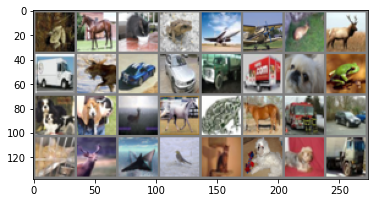

frog  horse cat   frog  plane plane deer  deer  truck deer  car   car   truck truck dog   frog  dog   dog   deer  horse frog  horse truck car   cat   deer  plane bird  cat   dog   dog   truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### (2) 모델

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### (3) 최적화(Optimization)

#### 학습/평가 함수 정의

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Batch size 조절

In [8]:
batch_size = 64

trainloader = DataLoader(trainset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=2)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2)

#### SGD

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.293692  [    0/50000]
loss: 2.295742  [ 6400/50000]
loss: 2.297808  [12800/50000]
loss: 2.267619  [19200/50000]
loss: 2.281593  [25600/50000]
loss: 2.279863  [32000/50000]
loss: 2.263644  [38400/50000]
loss: 2.263855  [44800/50000]
Test Error: 
 Accuracy: 21.9%, Avg loss: 2.245573 

Epoch 2
-------------------------------
loss: 2.238482  [    0/50000]
loss: 2.254648  [ 6400/50000]
loss: 2.244323  [12800/50000]
loss: 2.228243  [19200/50000]
loss: 2.239860  [25600/50000]
loss: 2.260375  [32000/50000]
loss: 2.160820  [38400/50000]
loss: 2.212028  [44800/50000]
Test Error: 
 Accuracy: 25.4%, Avg loss: 2.176106 

Epoch 3
-------------------------------
loss: 2.169509  [    0/50000]
loss: 2.226051  [ 6400/50000]
loss: 2.213853  [12800/50000]
loss: 2.189227  [19200/50000]
loss: 2.125378  [25600/50000]
loss: 2.122121  [32000/50000]
loss: 2.142814  [38400/50000]
loss: 2.132410  [44800/50000]
Test Error: 
 Accuracy: 27.4%, Avg loss: 2.104298 

Epoc

#### Adam

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 1.955676  [    0/50000]
loss: 1.632713  [ 6400/50000]
loss: 1.775993  [12800/50000]
loss: 1.690123  [19200/50000]
loss: 1.675104  [25600/50000]
loss: 1.806649  [32000/50000]
loss: 1.411925  [38400/50000]
loss: 1.652089  [44800/50000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.519838 

Epoch 2
-------------------------------
loss: 1.567723  [    0/50000]
loss: 1.338060  [ 6400/50000]
loss: 1.580534  [12800/50000]
loss: 1.464623  [19200/50000]
loss: 1.390098  [25600/50000]
loss: 1.247010  [32000/50000]
loss: 1.138307  [38400/50000]
loss: 1.340072  [44800/50000]
Test Error: 
 Accuracy: 50.7%, Avg loss: 1.401994 

Epoch 3
-------------------------------
loss: 1.086686  [    0/50000]
loss: 1.297018  [ 6400/50000]
loss: 1.309885  [12800/50000]
loss: 1.503715  [19200/50000]
loss: 1.130055  [25600/50000]
loss: 1.224178  [32000/50000]
loss: 1.178766  [38400/50000]
loss: 1.006044  [44800/50000]
Test Error: 
 Accuracy: 51.0%, Avg loss: 1.395725 

Epoc

#### RMSProp

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [14]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 0.991716  [    0/50000]
loss: 1.079390  [ 6400/50000]
loss: 1.131480  [12800/50000]
loss: 1.022511  [19200/50000]
loss: 1.077986  [25600/50000]
loss: 0.940558  [32000/50000]
loss: 1.186925  [38400/50000]
loss: 0.901020  [44800/50000]
Test Error: 
 Accuracy: 50.7%, Avg loss: 1.495792 

Epoch 2
-------------------------------
loss: 1.118121  [    0/50000]
loss: 0.869429  [ 6400/50000]
loss: 1.108241  [12800/50000]
loss: 0.972195  [19200/50000]
loss: 1.036140  [25600/50000]
loss: 1.015624  [32000/50000]
loss: 1.133452  [38400/50000]
loss: 1.314609  [44800/50000]
Test Error: 
 Accuracy: 49.9%, Avg loss: 1.609377 

Epoch 3
-------------------------------
loss: 0.897959  [    0/50000]
loss: 0.970680  [ 6400/50000]
loss: 0.970976  [12800/50000]
loss: 0.757338  [19200/50000]
loss: 0.768364  [25600/50000]
loss: 0.824895  [32000/50000]
loss: 0.724700  [38400/50000]
loss: 0.953345  [44800/50000]
Test Error: 
 Accuracy: 51.7%, Avg loss: 1.569529 

Epoc

### (4) Activation Functions

#### Sigmoid

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_sigmoid_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.Sigmoid(),
        nn.Linear(512, 512),
        nn.Sigmoid(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_sigmoid_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [17]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.387521  [    0/50000]
loss: 2.080253  [ 6400/50000]
loss: 1.685475  [12800/50000]
loss: 1.569470  [19200/50000]
loss: 1.628227  [25600/50000]
loss: 1.743974  [32000/50000]
loss: 1.514881  [38400/50000]
loss: 1.621338  [44800/50000]
Test Error: 
 Accuracy: 41.5%, Avg loss: 1.632037 

Epoch 2
-------------------------------
loss: 1.547049  [    0/50000]
loss: 1.657096  [ 6400/50000]
loss: 1.546405  [12800/50000]
loss: 1.318662  [19200/50000]
loss: 1.432243  [25600/50000]
loss: 1.359217  [32000/50000]
loss: 1.433583  [38400/50000]
loss: 1.535979  [44800/50000]
Test Error: 
 Accuracy: 43.9%, Avg loss: 1.558266 

Epoch 3
-------------------------------
loss: 1.525049  [    0/50000]
loss: 1.617144  [ 6400/50000]
loss: 1.436658  [12800/50000]
loss: 1.539125  [19200/50000]
loss: 1.422958  [25600/50000]
loss: 1.584058  [32000/50000]
loss: 1.399508  [38400/50000]
loss: 1.279449  [44800/50000]
Test Error: 
 Accuracy: 47.1%, Avg loss: 1.484587 

Epoc

#### tahn

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_tanh_stack = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.Tanh(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_tanh_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [20]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!!!")

Epoch 1
-------------------------------
loss: 2.319009  [    0/50000]
loss: 1.793744  [ 6400/50000]
loss: 1.740947  [12800/50000]
loss: 1.678033  [19200/50000]
loss: 1.909162  [25600/50000]
loss: 1.816203  [32000/50000]
loss: 1.762465  [38400/50000]
loss: 2.037732  [44800/50000]
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.855251 

Epoch 2
-------------------------------
loss: 2.041885  [    0/50000]
loss: 1.628734  [ 6400/50000]
loss: 1.640088  [12800/50000]
loss: 1.706230  [19200/50000]
loss: 1.616180  [25600/50000]
loss: 1.548855  [32000/50000]
loss: 1.829519  [38400/50000]
loss: 1.698912  [44800/50000]
Test Error: 
 Accuracy: 40.5%, Avg loss: 1.713610 

Epoch 3
-------------------------------
loss: 1.474062  [    0/50000]
loss: 1.656608  [ 6400/50000]
loss: 1.522774  [12800/50000]
loss: 1.612635  [19200/50000]
loss: 1.515466  [25600/50000]
loss: 1.462885  [32000/50000]
loss: 1.609338  [38400/50000]
loss: 1.834023  [44800/50000]
Test Error: 
 Accuracy: 42.5%, Avg loss: 1.653307 

Epoc